### 1. Read the data

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as smd

from typing import List
from sklearn import base, svm, pipeline, linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./data/auto-mpg.data-original', sep='\s+', engine='c', header=None)

df.head()

,0,1,2,3,4,5,6,7,8
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [3]:
# displacement (cu. in)
# weight (lbs)
# acceleration - ?
# model_year - delta from 1900
# origin: 1 - US, 2 - EU, 3 - Asia
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'name']
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


### 2. Clean the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     406 non-null    float64
 2   displacement  406 non-null    float64
 3   horsepower    400 non-null    float64
 4   weight        406 non-null    float64
 5   acceleration  406 non-null    float64
 6   model_year    406 non-null    float64
 7   origin        406 non-null    float64
 8   name          406 non-null    object 
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


In [5]:
no_mpg = df[df['mpg'].isna()]

In [6]:
df = df[~df['mpg'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    float64
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    float64
 7   origin        398 non-null    float64
 8   name          398 non-null    object 
dtypes: float64(8), object(1)
memory usage: 31.1+ KB


In [7]:
no_hp = df[df['horsepower'].isna()]

In [8]:
no_hp

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
133,21.0,6.0,200.0,NaN,2875.0,17.0,74.0,1.0,ford maverick
337,40.9,4.0,85.0,NaN,1835.0,17.3,80.0,2.0,renault lecar deluxe
343,23.6,4.0,140.0,NaN,2905.0,14.3,80.0,1.0,ford mustang cobra
361,34.5,4.0,100.0,NaN,2320.0,15.8,81.0,2.0,renault 18i
382,23.0,4.0,151.0,NaN,3035.0,20.5,82.0,1.0,amc concord dl


Searching online for the car model we've found the car's specs where the horsepower value is present:
* https://www.automobile-catalog.com/make/ford_usa/pinto/pinto_2-door_sedan/1971.html
* https://www.automobile-catalog.com/make/ford_usa/maverick_usa/maverick_usa_2-door_sedan/1974.html
* https://www.automobile-catalog.com/car/1980/2928200/renault_le_car.html
* https://www.automobile-catalog.com/car/1980/865730/ford_mustang_cobra_2_3l_turbo.html
* https://www.automobile-catalog.com/car/1981/2930765/renault_18i_sedan_4-speed.html
* https://www.automobile-catalog.com/make/amc/concord/concord_2-door_dl/1982.html

In [9]:
df.loc[no_hp.index, 'horsepower'] = [75, 84, 53.5, 120, 81.5, 82]

In [10]:
df[df['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name


### 3. Transform the data

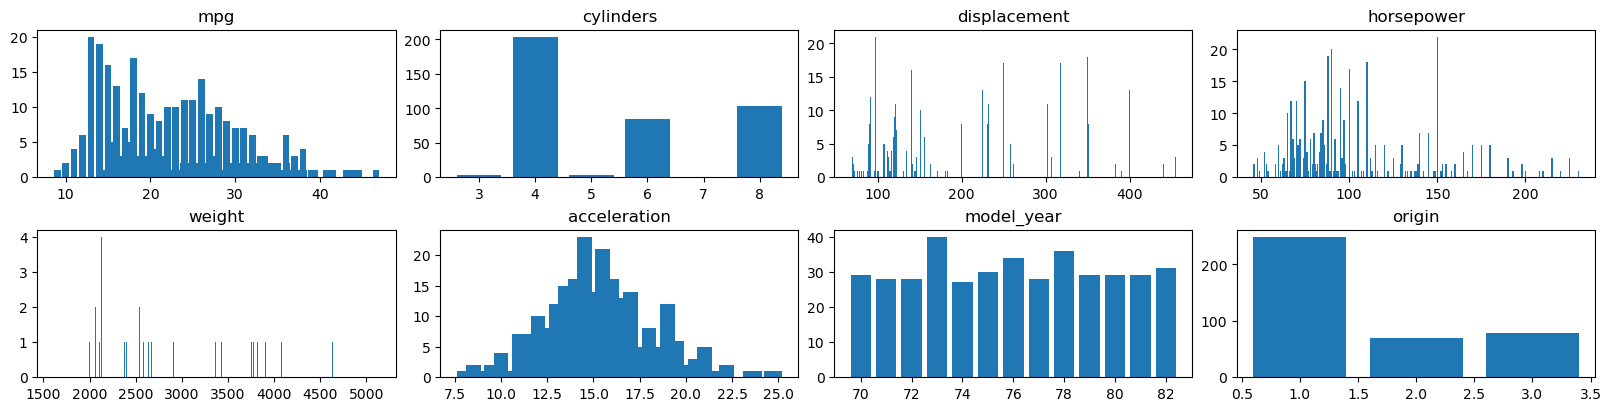

In [11]:
nrow = 2
ncol = (len(df.columns) - 1) // 2
fig, axs = plt.subplots(nrow, ncol, layout='constrained')

fig.set_size_inches(16, 4)

for i, col in enumerate(df.columns[:-1]): # create histogram for all columns except car name
    vc = df[col].value_counts()
    axs[i // ncol][i % ncol].bar(vc.index, vc.values)
    axs[i // ncol][i % ncol].set_title(col)


In [12]:
df['cylinders'] = df['cylinders'].astype(int)
df['model_year'] = df['model_year'].astype(int)
df['origin'] = df['origin'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int32  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int32  
 7   origin        398 non-null    int32  
 8   name          398 non-null    object 
dtypes: float64(5), int32(3), object(1)
memory usage: 42.6+ KB


In [13]:
car_name_df = df['name'].str.extract(r'(\w+) ?(.*)?')
df['name'] = car_name_df[1]
df['manufacturer'] = car_name_df[0]

df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,manufacturer
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,skylark 320,buick
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,satellite,plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,rebel sst,amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,torino,ford
...,...,...,...,...,...,...,...,...,...,...
401,27.0,4,140.0,86.0,2790.0,15.6,82,1,mustang gl,ford
402,44.0,4,97.0,52.0,2130.0,24.6,82,2,pickup,vw
403,32.0,4,135.0,84.0,2295.0,11.6,82,1,rampage,dodge
404,28.0,4,120.0,79.0,2625.0,18.6,82,1,ranger,ford


In [14]:
df[(df.name.isna()) | (df.manufacturer.isna())]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,manufacturer


In [15]:
df.groupby(['origin', 'manufacturer']).count()

mpg  cylinders  displacement  horsepower  weight  \
origin manufacturer                                                     
1      amc            28         28            28          28      28   
       buick          17         17            17          17      17   
       cadillac        2          2             2           2       2   
       capri           1          1             1           1       1   
       chevroelt       1          1             1           1       1   
       chevrolet      43         43            43          43      43   
       chevy           3          3             3           3       3   
       chrysler        6          6             6           6       6   
       dodge          28         28            28          28      28   
       ford           51         51            51          51      51   
       hi              1          1             1           1       1   
       mercury        11         11            11          11      11   
       oldsmobile     10         10            10          10      10   
       plymouth       31         31            31          31      31   
       pontiac        16         16            16          16      16   
2      audi            7          7             7           7       7   
       bmw             2          2             2           2       2   
       fiat            8          8             8           8       8   
       mercedes        3          3             3           3       3   
       opel            4          4             4           4       4   
       peugeot         8          8             8           8       8   
       renault         5          5             5           5       5   
       saab            4          4             4           4       4   
       triumph         1          1             1           1       1   
       vokswagen       1          1             1           1       1   
       volkswagen     15         15            15          15      15   
       volvo           6          6             6           6       6   
       vw              6          6             6           6       6   
3      datsun         23         23            23          23      23   
       honda          13         13            13          13      13   
       maxda           2          2             2           2       2   
       mazda          10         10            10          10      10   
       nissan          1          1             1           1       1   
       subaru          4          4             4           4       4   
       toyota         25         25            25          25      25   
       toyouta         1          1             1           1       1   

                     acceleration  model_year  name  
origin manufacturer                                  
1      amc                     28          28    28  
       buick                   17          17    17  
       cadillac                 2           2     2  
       capri                    1           1     1  
       chevroelt                1           1     1  
       chevrolet               43          43    43  
       chevy                    3           3     3  
       chrysler                 6           6     6  
       dodge                   28          28    28  
       ford                    51          51    51  
       hi                       1           1     1  
       mercury                 11          11    11  
       oldsmobile              10          10    10  
       plymouth                31          31    31  
       pontiac                 16          16    16  
2      audi                     7           7     7  
       bmw                      2           2     2  
       fiat                     8           8     8  
       mercedes                 3           3     3  
       opel                     4           4     4  
       peugeot                  8           8     8  
    

In [16]:
manufacturer_mappings = {
    'chevroelt': 'chevrolet',
    'chevy': 'chevrolet',
    'vw': 'volkswagen',
    'vokswagen': 'volkswagen',
    'maxda': 'mazda',
    'toyouta': 'toyota'
}

df.manufacturer.replace(manufacturer_mappings, inplace=True)

In [17]:
"""
origin:
    1 - US
    2 - Europe
    3 - Asia
"""
df.groupby(['origin', 'manufacturer']).count()

mpg  cylinders  displacement  horsepower  weight  \
origin manufacturer                                                     
1      amc            28         28            28          28      28   
       buick          17         17            17          17      17   
       cadillac        2          2             2           2       2   
       capri           1          1             1           1       1   
       chevrolet      47         47            47          47      47   
       chrysler        6          6             6           6       6   
       dodge          28         28            28          28      28   
       ford           51         51            51          51      51   
       hi              1          1             1           1       1   
       mercury        11         11            11          11      11   
       oldsmobile     10         10            10          10      10   
       plymouth       31         31            31          31      31   
       pontiac        16         16            16          16      16   
2      audi            7          7             7           7       7   
       bmw             2          2             2           2       2   
       fiat            8          8             8           8       8   
       mercedes        3          3             3           3       3   
       opel            4          4             4           4       4   
       peugeot         8          8             8           8       8   
       renault         5          5             5           5       5   
       saab            4          4             4           4       4   
       triumph         1          1             1           1       1   
       volkswagen     22         22            22          22      22   
       volvo           6          6             6           6       6   
3      datsun         23         23            23          23      23   
       honda          13         13            13          13      13   
       mazda          12         12            12          12      12   
       nissan          1          1             1           1       1   
       subaru          4          4             4           4       4   
       toyota         26         26            26          26      26   

                     acceleration  model_year  name  
origin manufacturer                                  
1      amc                     28          28    28  
       buick                   17          17    17  
       cadillac                 2           2     2  
       capri                    1           1     1  
       chevrolet               47          47    47  
       chrysler                 6           6     6  
       dodge                   28          28    28  
       ford                    51          51    51  
       hi                       1           1     1  
       mercury                 11          11    11  
       oldsmobile              10          10    10  
       plymouth                31          31    31  
       pontiac                 16          16    16  
2      audi                     7           7     7  
       bmw                      2           2     2  
       fiat                     8           8     8  
       mercedes                 3           3     3  
       opel                     4           4     4  
       peugeot                  8           8     8  
       renault                  5           5     5  
       saab                     4           4     4  
       triumph                  1           1     1  
       volkswagen              22          22    22  
       volvo                    6           6     6  
3      datsun                  23          23    23  
       honda                   13          13    13  
       mazda                   12          12    12  
       nissan                   1           1     1  
       subaru                   4           4     4  
       toy

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int32  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int32  
 7   origin        398 non-null    int32  
 8   name          398 non-null    object 
 9   manufacturer  398 non-null    object 
dtypes: float64(5), int32(3), object(2)
memory usage: 45.7+ KB


### 4. Explore the data

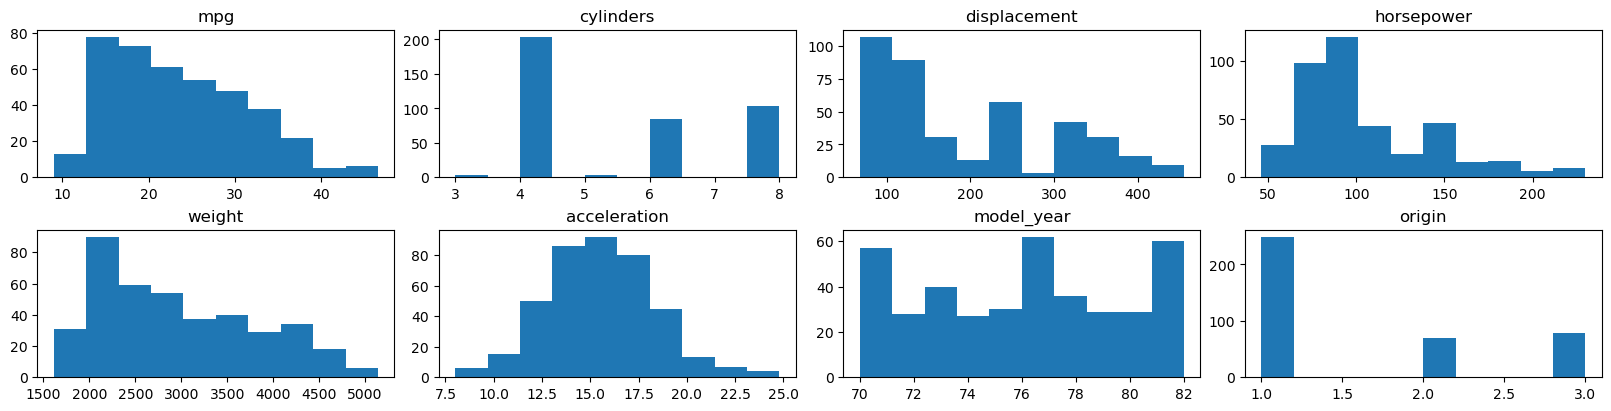

In [19]:
nrow = 2
ncol = (len(df.columns) - 1) // 2
fig, axs = plt.subplots(nrow, ncol, layout='constrained')

fig.set_size_inches(16, 4)

for i, col in enumerate(df.columns[:-2]): # create histogram for all columns except [manufacturer, name]
    axs[i // ncol][i % ncol].hist(df[col])
    axs[i // ncol][i % ncol].set_title(col)

In [20]:
df[(df.cylinders == 3) | (df.cylinders == 5)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,manufacturer
78,19.0,3,70.0,97.0,2330.0,13.5,72,3,rx2 coupe,mazda
118,18.0,3,70.0,90.0,2124.0,13.5,73,3,rx3,mazda
250,21.5,3,80.0,110.0,2720.0,13.5,77,3,rx-4,mazda
281,20.3,5,131.0,103.0,2830.0,15.9,78,2,5000,audi
304,25.4,5,183.0,77.0,3530.0,20.1,79,2,benz 300d,mercedes
334,36.4,5,121.0,67.0,2950.0,19.9,80,2,5000s (diesel),audi
341,23.7,3,70.0,100.0,2420.0,12.5,80,3,rx-7 gs,mazda


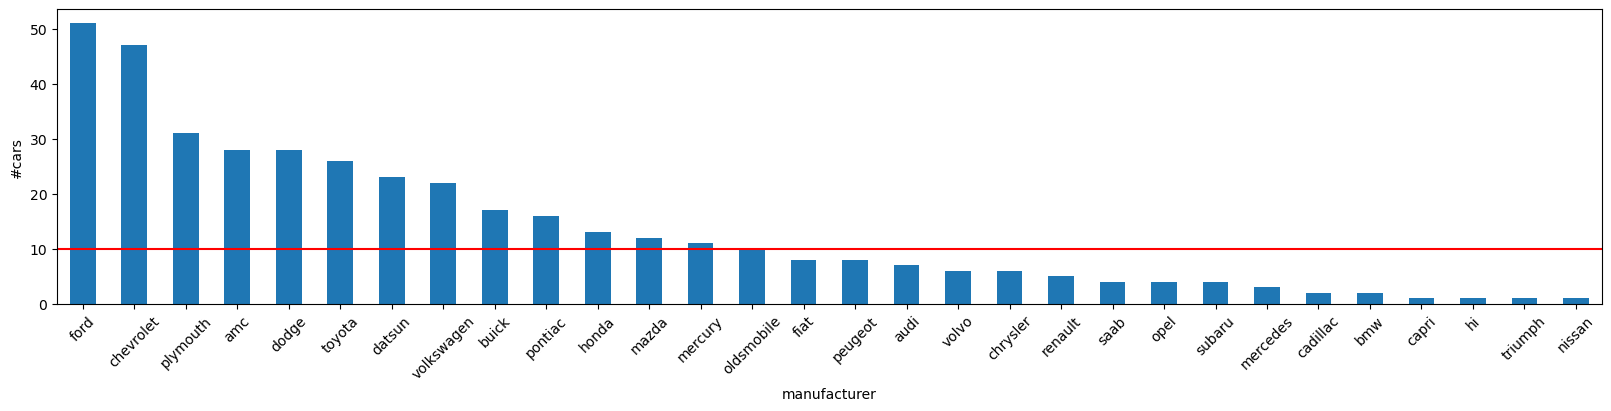

In [21]:
fig, ax = plt.subplots(layout='constrained')

fig.set_size_inches(16, 4)

df['manufacturer'].value_counts().plot(kind='bar', ax=ax)

ax.set_ylabel('#cars')
ax.set_xlabel('manufacturer')

ax.tick_params('x', rotation=45)

ax.hlines(10, -1, 100, colors='red')

plt.show()

In [22]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.140704,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.367493,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


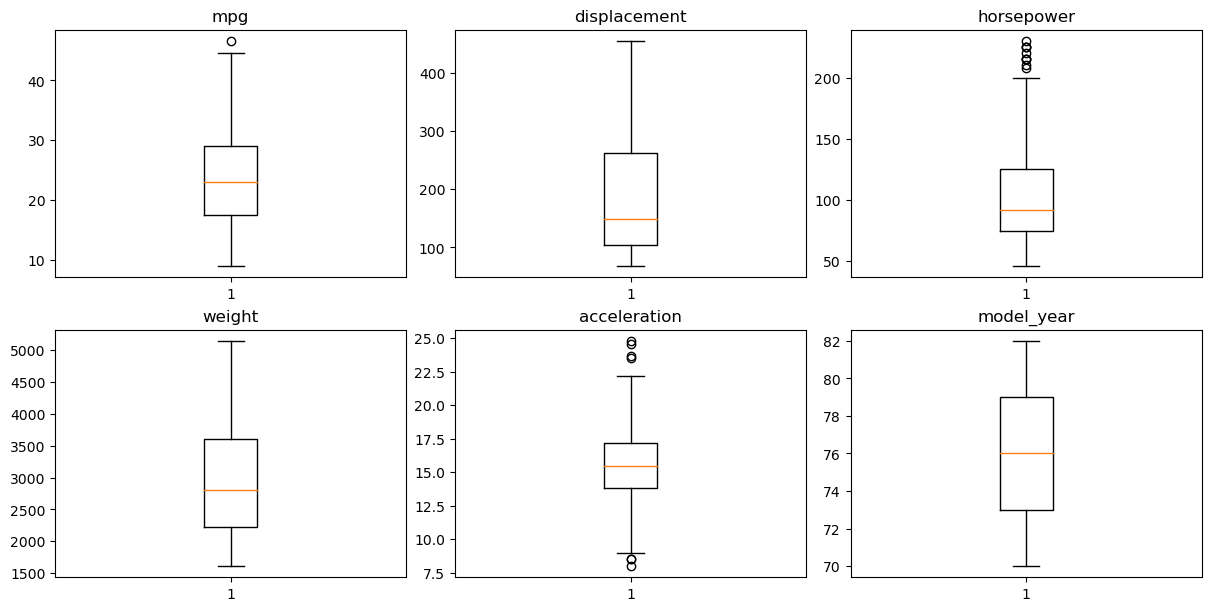

In [23]:
nrows = 2
cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
ncols = len(cols) // nrows

fig, axs = plt.subplots(nrows, ncols, layout='constrained')

fig.set_size_inches(12, 6)

for i, col in enumerate(cols):
    axs[i // ncols][i % ncols].boxplot(df[col].values)
    axs[i // ncols][i % ncols].set_title(col)

In [24]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

C:\Users\Alex\AppData\Local\Temp\ipykernel_3928\1135615777.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
mpg,1.00,-0.78,-0.80,-0.78,-0.83,0.42,0.58,0.56
cylinders,-0.78,1.00,0.95,0.84,0.90,-0.51,-0.35,-0.56
displacement,-0.80,0.95,1.00,0.90,0.93,-0.54,-0.37,-0.61
horsepower,-0.78,0.84,0.90,1.00,0.86,-0.69,-0.41,-0.45
weight,-0.83,0.90,0.93,0.86,1.00,-0.42,-0.31,-0.58
acceleration,0.42,-0.51,-0.54,-0.69,-0.42,1.00,0.29,0.21
model_year,0.58,-0.35,-0.37,-0.41,-0.31,0.29,1.00,0.18
origin,0.56,-0.56,-0.61,-0.45,-0.58,0.21,0.18,1.00


### 5. Model the data

In [25]:
def one_hot_encode(frame: pd.DataFrame, column: str) -> pd.DataFrame:
    one_hot_df = frame.pivot(columns=column, values=column)
    return one_hot_df.notnull().astype(int)

In [26]:
origin_df = one_hot_encode(df, 'origin')
origin_df.columns = ['us', 'europe', 'asia']

df = df.join(origin_df)
df.drop(columns=['origin'], inplace=True)

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,name,manufacturer,us,europe,asia
0,18.0,8,307.0,130.0,3504.0,12.0,70,chevelle malibu,chevrolet,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,skylark 320,buick,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,satellite,plymouth,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,rebel sst,amc,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,torino,ford,1,0,0


In [27]:
train_df, test_df = train_test_split(df, test_size=.2, random_state=0)

print(f'train_df size: {len(train_df)}')
print(f'test_df size: {len(test_df)}')

train_df size: 318
test_df size: 80


In [28]:
exog_vars = df.columns.difference(["mpg", "name", 'manufacturer'])
result = smf.ols(f'mpg ~ {"+".join(exog_vars)}', train_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     177.5
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          9.93e-111
Time:                        16:58:36   Log-Likelihood:                -829.15
No. Observations:                 318   AIC:                             1676.
Df Residuals:                     309   BIC:                             1710.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -13.1331      3.875     -3.389      0.001     -20.758      -5.509
acceleration     0.1850      0.111      1.665      0.097      -0.034       0.404
asia            -3.1665      1.366     -2.319      0.021      -5.854      -0.479
cylinders       -0.4059      0.358     -1.134      0.258      -1.110       0.298
displacement     0.0253      0.009      2.887      0.004       0.008       0.043
europe          -3.6538      1.298     -2.815      0.005      -6.208      -1.100
horsepower      -0.0217      0.015     -1.406      0.161      -0.052       0.009
model_year       0.7654      0.058     13.268      0.000       0.652       0.879
us              -6.3129      1.356     -4.656      0.000      -8.981      -3.645
weight          -0.0066      0.001     -9.077      0.000      -0.008      -0.005
==============================================================================
Omnibus:                       22.613   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.876
Skew:                           0.489   Prob(JB):                     4.41e-08
Kurtosis:                       4.265   Cond. No.                     1.60e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
exog_vars = df.columns.difference(["mpg", "name", 'manufacturer'])
result = smf.ols(f'np.log10(mpg) ~ {"+".join(exog_vars)}', train_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log10(mpg)   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     281.6
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          5.19e-137
Time:                        16:58:36   Log-Likelihood:                 496.45
No. Observations:                 318   AIC:                            -974.9
Df Residuals:                     309   BIC:                            -941.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5520      0.060      9.206      0.000       0.434       0.670
acceleration     0.0010      0.002      0.603      0.547      -0.002       0.004
asia             0.1965      0.021      9.299      0.000       0.155       0.238
cylinders       -0.0093      0.006     -1.686      0.093      -0.020       0.002
displacement     0.0003      0.000      2.404      0.017    5.91e-05       0.001
europe           0.1956      0.020      9.740      0.000       0.156       0.235
horsepower      -0.0007      0.000     -2.810      0.005      -0.001      -0.000
model_year       0.0132      0.001     14.761      0.000       0.011       0.015
us               0.1599      0.021      7.619      0.000       0.119       0.201
weight          -0.0001   1.13e-05    -10.114      0.000      -0.000   -9.22e-05
==============================================================================
Omnibus:                        6.111   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                7.301
Skew:                          -0.181   Prob(JB):                       0.0260
Kurtosis:                       3.648   Cond. No.                     1.60e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
result.pvalues[result.pvalues < .05].index.difference(['Intercept'])

Index(['asia', 'displacement', 'europe', 'horsepower', 'model_year', 'us',
       'weight'],
      dtype='object')

In [31]:
exog_vars = ['asia', 'displacement', 'europe', 'horsepower', 'model_year', 'us', 'weight']
result = smf.ols(f'np.log10(mpg) ~ {"+".join(exog_vars)}', train_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log10(mpg)   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     373.3
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          7.25e-139
Time:                        16:58:36   Log-Likelihood:                 494.74
No. Observations:                 318   AIC:                            -975.5
Df Residuals:                     311   BIC:                            -949.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5473      0.053     10.231      0.000       0.442       0.653
asia             0.1939      0.019     10.202      0.000       0.157       0.231
displacement     0.0002   9.92e-05      1.618      0.107   -3.47e-05       0.000
europe           0.1941      0.018     10.840      0.000       0.159       0.229
horsepower      -0.0007      0.000     -3.815      0.000      -0.001      -0.000
model_year       0.0132      0.001     14.783      0.000       0.011       0.015
us               0.1593      0.019      8.356      0.000       0.122       0.197
weight          -0.0001      1e-05    -11.226      0.000      -0.000    -9.3e-05
==============================================================================
Omnibus:                        6.745   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                8.617
Skew:                          -0.174   Prob(JB):                       0.0135
Kurtosis:                       3.727   Cond. No.                     1.28e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.87e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [32]:
result.pvalues[result.pvalues < .05].index.difference(['Intercept'])

Index(['asia', 'europe', 'horsepower', 'model_year', 'us', 'weight'], dtype='object')

In [33]:
exog_vars = ['asia', 'europe', 'horsepower', 'model_year', 'us', 'weight']
result = smf.ols(f'np.log10(mpg) ~ {"+".join(exog_vars)}', train_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log10(mpg)   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     445.2
Date:                Thu, 10 Aug 2023   Prob (F-statistic):          1.20e-139
Time:                        16:58:36   Log-Likelihood:                 493.41
No. Observations:                 318   AIC:                            -974.8
Df Residuals:                     312   BIC:                            -952.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5442      0.054     10.154      0.000       0.439       0.650
asia           0.1918      0.019     10.089      0.000       0.154       0.229
europe         0.1905      0.018     10.694      0.000       0.155       0.226
horsepower    -0.0006      0.000     -3.453      0.001      -0.001      -0.000
model_year     0.0130      0.001     14.657      0.000       0.011       0.015
us             0.1620      0.019      8.506      0.000       0.125       0.199
weight        -0.0001   7.63e-06    -13.400      0.000      -0.000   -8.72e-05
==============================================================================
Omnibus:                        6.053   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                8.225
Skew:                          -0.112   Prob(JB):                       0.0164
Kurtosis:                       3.756   Cond. No.                     3.35e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.7e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# Perform the Breusch-Pagan test
# Null hypothesis: "The residuals do not depend on the values of the independent variables. (homoskedasticity)"
# Chosen significance threshold: 5%

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = smd.het_breuschpagan(result.resid, result.model.exog)
list(zip(name, test))

[('Lagrange multiplier statistic', 6.987753709411884),
 ('p-value', 0.3219812156684642),
 ('f-value', 1.4019892678434922),
 ('f p-value', 0.2232141079667259)]

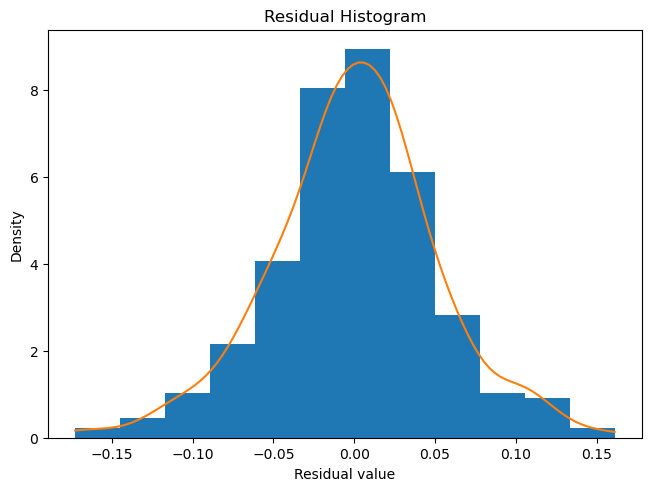

In [35]:
### Residual Analysis

fig, ax = plt.subplots(layout='constrained')

residuals = result.resid
density = stats.gaussian_kde(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)

ax.hist(residuals, bins=12, density=True)
ax.plot(x, density(x))

ax.set_title("Residual Histogram")
ax.set_ylabel("Density")
ax.set_xlabel("Residual value")

plt.show()

Text(0, 0.5, 'Residuals')

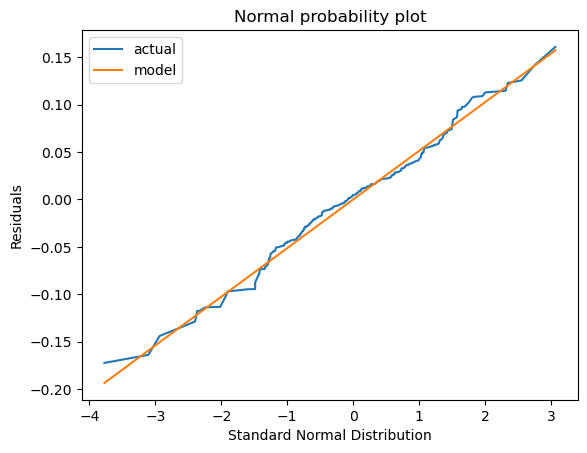

In [36]:
fig, ax = plt.subplots()

rng = np.random.default_rng(seed=0)

std_norm = rng.standard_normal(len(residuals))
std_norm.sort()
residuals = residuals.sort_values()
resid_std, resid_mean = residuals.std(), residuals.mean()

ax.plot(std_norm, residuals, label='actual')
ax.plot(std_norm, std_norm * resid_std + resid_mean, label='model')

ax.legend()
ax.set_title('Normal probability plot')
ax.set_xlabel('Standard Normal Distribution')
ax.set_ylabel('Residuals')

Text(0.5, 0, 'Predicted')

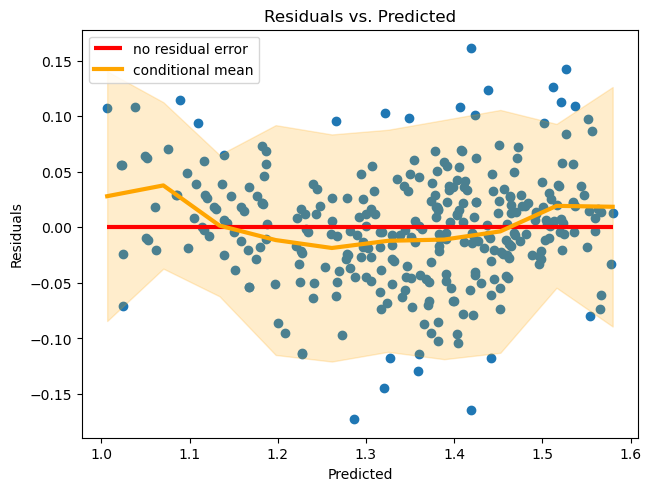

In [37]:
residuals = result.resid
predicted = result.predict(train_df).values

predicted_sort_idx = predicted.argsort()

conditional = residuals.groupby(pd.cut(predicted, 10))
conditional_mean = conditional.mean()
conditional_sd = conditional.std()

x = np.linspace(predicted.min(), predicted.max(), len(conditional_mean))

fig, ax = plt.subplots(layout='constrained')

ax.scatter(predicted, residuals)
ax.hlines([0], [predicted.min()], [predicted.max()], colors=['r'], linewidth=3, label='no residual error')

ax.plot(x, conditional_mean, color='orange', linewidth=3, label='conditional mean')
ax.fill_between(x, conditional_mean + 2 * conditional_sd, conditional_mean - 2 * conditional_sd, alpha=.2, color='orange')

ax.legend()

ax.set_title("Residuals vs. Predicted")
ax.set_ylabel("Residuals")
ax.set_xlabel("Predicted")

In [38]:
# Perform k-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_rsquared = []
train_mse = []
val_rsquared = []
val_mse = []

for (train_idx, val_idx) in kf.split(train_df[exog_vars]):
    train_set, val_set = train_df.iloc[train_idx], train_df.iloc[val_idx]
    result = smf.ols(f'np.log10(mpg) ~ {"+".join(exog_vars)}', data=train_set).fit()

    train_rsquared.append(result.rsquared)
    train_mse.append(result.mse_resid)

    yhat_val = result.predict(exog=val_set[exog_vars])
    ytrue_val = np.log10(val_set['mpg']) # take the log10 to match the model output

    val_rsquared.append(r2_score(ytrue_val, yhat_val))
    val_mse.append(mean_squared_error(ytrue_val, yhat_val))

In [39]:
print('Model: OLS')
print(f'train R^2: {np.mean(train_rsquared):.3f} (std: {np.std(train_rsquared):.2f}), train MSE: {np.mean(train_mse):.4f} (std: {np.std(train_mse):.4f})')
print(f'val R^2: {np.mean(val_rsquared):.3f} (std: {np.std(val_rsquared):.2f}), val MSE: {np.mean(val_mse):.4f} (std: {np.std(val_mse):.4f})')

del train_rsquared
del train_mse
del val_rsquared
del val_mse

Model: OLS
train R^2: 0.877 (std: 0.01), train MSE: 0.0027 (std: 0.0001)
val R^2: 0.862 (std: 0.05), val MSE: 0.0027 (std: 0.0010)


In [40]:
columns_to_preprocess = train_df.columns.difference(['name', 'mpg', 'manufacturer', 'us', 'europe', 'asia'])
print(columns_to_preprocess, len(columns_to_preprocess))

exog_vars = train_df.columns.difference(['name', 'mpg', 'manufacturer'])
print(exog_vars, len(exog_vars))

Index(['acceleration', 'cylinders', 'displacement', 'horsepower', 'model_year',
       'weight'],
      dtype='object') 6
Index(['acceleration', 'asia', 'cylinders', 'displacement', 'europe',
       'horsepower', 'model_year', 'us', 'weight'],
      dtype='object') 9


In [41]:
train_features = train_df[exog_vars]
train_target = train_df['mpg']

test_features = test_df[exog_vars]
test_target = test_df['mpg']

In [42]:
scaled_train_features = train_features.copy()
for column in columns_to_preprocess:
    scaled_train_features[column] = StandardScaler().fit_transform(scaled_train_features[column].values.reshape(-1, 1))

# There's data leakage due to how we scaled the train_features so the results of the model don't make sense
# The reason for doing this is to quickly check what would be the best hyperparameters for some models
scaled_train_features.head()

,acceleration,asia,cylinders,displacement,europe,horsepower,model_year,us,weight
71,-0.795208,0,1.495269,1.229613,0,1.242024,-1.137525,1,1.388329
62,1.244115,0,-0.852857,-0.923677,1,-1.160025,-1.411773,0,-1.338307
324,0.057600,0,-0.852857,-0.923677,1,-0.679615,1.056458,0,-0.918824
109,1.985687,0,-0.852857,-0.923677,1,-1.533677,-0.863277,0,-1.200849
365,0.984565,1,-0.852857,-0.699579,0,-0.786373,1.330706,0,-0.389139


In [43]:
mock_model = linear_model.ElasticNetCV(cv=10, random_state=0).fit(scaled_train_features, train_target)

# The alpha here is very small, showing that lower regularization leads to better r^2
print(f'ElasticNet R^2: {mock_model.score(scaled_train_features, train_target)} alpha: {mock_model.alpha_}, l1_ratio: {mock_model.l1_ratio_}')

# Compared to plain OLS model
mock_model = linear_model.LinearRegression()
print(f'Linear regressor R^2: {np.mean(cross_val_score(mock_model, scaled_train_features, train_target, cv=10))}')

del scaled_train_features

ElasticNet R^2: 0.8205601613394251 alpha: 0.012791845725707638, l1_ratio: 0.5
Linear regressor R^2: 0.8097714367640491


In [44]:
class MultiColumnStandardScaler(base.TransformerMixin):
    """
        Custom scaler that uses StandardScaler to scale only certain columns
        * param: columns - columns to be scaled by StandardScaler
    """
    def __init__(self, columns: List[str]) -> None:
        self.__cols = columns
        self.__scalers = dict()
    
    def fit(self, X, y=None):
        for col in self.__cols:
            scaler = StandardScaler()
            scaler.fit(X[col].values.reshape(-1, 1))
            self.__scalers[col] = scaler

        return self
    
    def transform(self, X):
        new_data = X.copy()
        for col in self.__cols:
            scaler = self.__scalers[col]
            new_data[col] = scaler.transform(X[col].values.reshape(-1, 1))
        return new_data

In [45]:
# Test the scaler to see if it works
scaler = MultiColumnStandardScaler(columns_to_preprocess)

x_train, x_val = train_test_split(train_features, test_size=0.2, random_state=0)

x_train.shape, x_val.shape

scaler.fit(x_train)

scaled_x_train = scaler.transform(x_train)
scaled_x_train.describe().T
scaled_x_val = scaler.transform(x_val)
scaled_x_val.describe().T

,count,mean,std,min,25%,50%,75%,max
acceleration,64.0,0.234024,1.067196,-1.703410,-0.469105,0.030270,0.821732,3.497629
asia,64.0,0.203125,0.405505,0.000000,0.000000,0.000000,0.000000,1.000000
cylinders,64.0,-0.011298,1.021594,-1.446135,-0.857484,-0.857484,1.497120,1.497120
displacement,64.0,-0.015062,0.995399,-1.177133,-0.924430,-0.448181,1.068039,2.020536
europe,64.0,0.187500,0.393398,0.000000,0.000000,0.000000,0.000000,1.000000
horsepower,64.0,-0.115276,0.839123,-1.510452,-0.805181,-0.242257,0.463014,1.698858
model_year,64.0,0.225511,0.924808,-1.620585,-0.536639,0.276321,0.818294,1.631254
us,64.0,0.609375,0.491747,0.000000,0.000000,1.000000,1.000000,1.000000
weight,64.0,0.071418,1.060807,-1.385638,-0.920123,-0.109516,0.841584,2.451115


In [46]:
rbf_params = {
    'reg__C': [0.1, 1, 10, 100, 1000],
    'reg__gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

pipe = pipeline.Pipeline(steps=[('scaler', MultiColumnStandardScaler(columns_to_preprocess)),
                                ('reg', svm.SVR(kernel='rbf'))])
search = GridSearchCV(pipe, param_grid=rbf_params, refit=True, cv=kf)

search.fit(train_features, train_target)

print(f'Best CV score: {search.best_score_:.3f}')
print(search.best_params_)

Best CV score: 0.875
{'reg__C': 100, 'reg__gamma': 0.1}


In [47]:
best_model = search.best_estimator_

print(f'Model: SVM[kernel=rbf, C={search.best_params_["reg__C"]}, gamma={search.best_params_["reg__gamma"]}]')
print(f'Train R^2: {best_model.score(train_features, train_target):.3f}')
print(f'Test R^2: {best_model.score(test_features, test_target):.3f}')

Model: SVM[kernel=rbf, C=100, gamma=0.1]
Train R^2: 0.926
Test R^2: 0.911


In [48]:
exog_vars = ['asia', 'europe', 'horsepower', 'model_year', 'us', 'weight']
formula = f'np.log10(mpg) ~ {" + ".join(exog_vars)}'

result = smf.ols(formula, data=train_df).fit()
print(f'Model: OLS[{formula}]')
print(f'Train R^2: {result.rsquared:.3f}')
print(f'Test R^2: {r2_score(np.log10(test_df["mpg"]), result.predict(exog=test_df[exog_vars])):.3f}')

Model: OLS[np.log10(mpg) ~ asia + europe + horsepower + model_year + us + weight]
Train R^2: 0.877
Test R^2: 0.885
